# Hands-on Exercise #4 

### To Do: On Customer Churn Dataset got to do these 
#### - Ensemble Methods: Random Forests and XGBoost
#### - Instance-Based Learning: K-Nearest Neighbors 
#### - Clustering (Unsupervised Learning): K-Means Clustering and Hierarchical Clustering

In [4]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


## Load and Explore Data

In [6]:
df = pd.read_csv("telco_customer_churn4.csv")
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   churn                        7043 non-null   int64
 1   senior_citizen               7043 non-null   int64
 2   has_dependents               7043 non-null   int64
 3   months_as_cutomer            7043 non-null   int64
 4   has_internet_service         7043 non-null   int64
 5   has_month_to_month_contract  7043 non-null   int64
dtypes: int64(6)
memory usage: 330.3 KB
None
             churn  senior_citizen  has_dependents  months_as_cutomer  \
count  7043.000000     7043.000000     7043.000000        7043.000000   
mean      0.265370        0.162147        0.299588          32.371149   
std       0.441561        0.368612        0.458110          24.559481   
min       0.000000        0.000000        0.000000           0.000000   
25%       0.000000        0.000000  

##  Outlier Detection using Boxplots

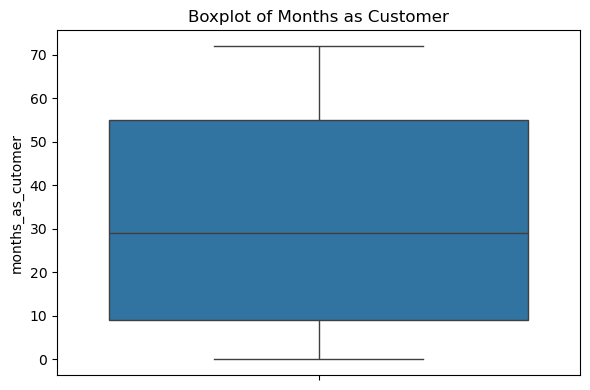

In [8]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df["months_as_cutomer"])  
plt.title("Boxplot of Months as Customer")
plt.tight_layout()
plt.show()

## Balance Dataset with SMOTE

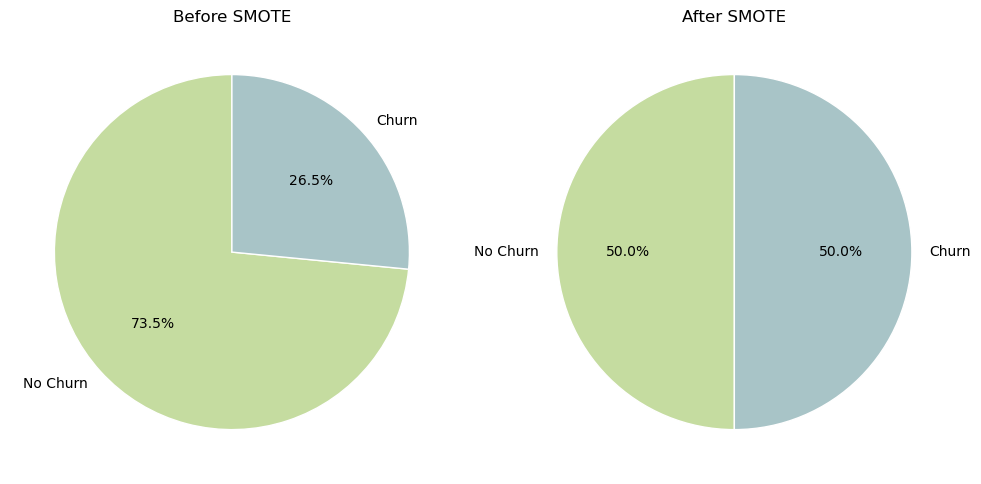

In [10]:
X = df.drop("churn", axis=1)
y = df["churn"]
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
# Prepare labels and colors
labels = ['No Churn', 'Churn']
#colors = ['#66b3ff', '#ff9999']
colors = ['#C5DCA0', '#A8C4C7']

# Plot pie charts
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Before SMOTE
y.value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    labels=labels, 
    colors=colors, 
    ax=ax[0],
    wedgeprops={'edgecolor': 'white'}
)
ax[0].set_title("Before SMOTE")
ax[0].set_ylabel("")

# After SMOTE
y_resampled.value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    labels=labels, 
    colors=colors, 
    ax=ax[1],
    wedgeprops={'edgecolor': 'white'}
)
ax[1].set_title("After SMOTE")
ax[1].set_ylabel("")

plt.tight_layout()
plt.show()


## Standardize Features (for KNN & Clustering)

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)


# Ensemble Models: Random Forest and XGBoost 
# Instance Based: k-NN

In [14]:
def evaluate_model(model, X, y, model_name):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    prec = cross_val_score(model, X, y, scoring='precision', cv=cv)
    rec = cross_val_score(model, X, y, scoring='recall', cv=cv)
    print(f"🔍 {model_name}:\nAccuracy: {acc.mean():.3f}, Precision: {prec.mean():.3f}, Recall: {rec.mean():.3f}\n")

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
evaluate_model(rf, X_resampled, y_resampled, "Random Forest")

# XGBoost
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=4, use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb, X_resampled, y_resampled, "XGBoost")

# KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
evaluate_model(knn, X_scaled, y_resampled, "K-Nearest Neighbors")

🔍 Random Forest:
Accuracy: 0.753, Precision: 0.720, Recall: 0.828

🔍 XGBoost:
Accuracy: 0.755, Precision: 0.721, Recall: 0.833

🔍 K-Nearest Neighbors:
Accuracy: 0.654, Precision: 0.745, Recall: 0.462



# ROC Curve Visualization

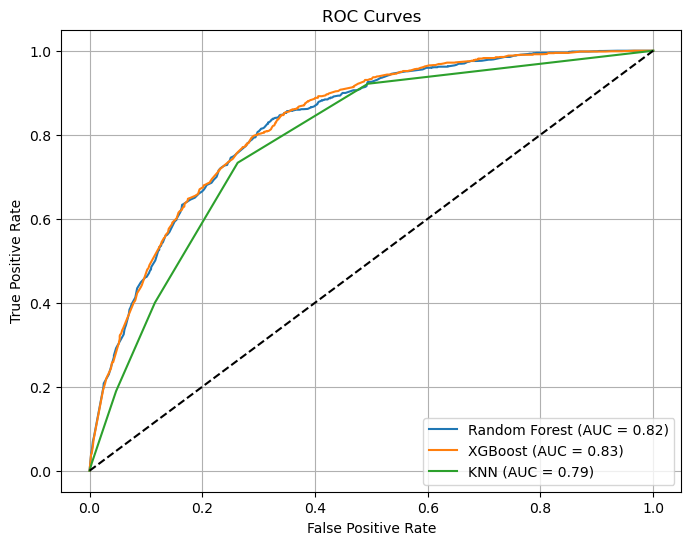

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

plt.figure(figsize=(8, 6))
for name, model in models.items():
    if name == "KNN":
        model.fit(X_scaled, y_resampled)
        proba = model.predict_proba(scaler.transform(X_test))[:, 1]
    else:
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, proba):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


# Clustering Models : i) K-Means and Hierarchical Clustering

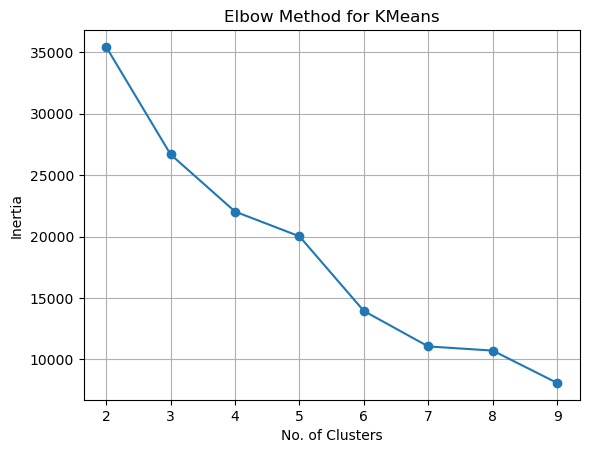

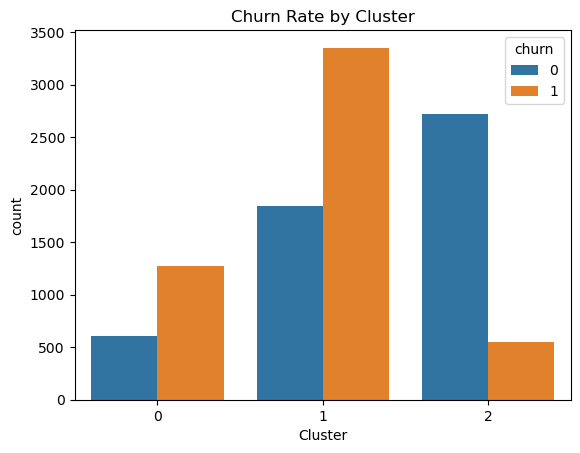

In [18]:
inertias = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(range(2, 10), inertias, marker='o')
plt.title("Elbow Method for KMeans")
plt.xlabel("No. of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()

# Cluster and profile
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_clustered = pd.DataFrame(X_resampled, columns=X.columns)
df_clustered['churn'] = y_resampled
df_clustered['Cluster'] = clusters

# Churn distribution by cluster
sns.countplot(x='Cluster', hue='churn', data=df_clustered)
plt.title("Churn Rate by Cluster")
plt.show()


In [19]:
df.head()

,churn,senior_citizen,has_dependents,months_as_cutomer,has_internet_service,has_month_to_month_contract
0,0,0,0,1,1,1
1,0,0,0,34,1,0
2,1,0,0,2,1,1
3,0,0,0,45,1,0
4,1,0,0,2,1,1


📊 Cluster Profiles:


,senior_citizen,has_dependents,months_as_cutomer,has_internet_service,has_month_to_month_contract,churn
Cluster,,,,,,
0,1.00,0.03,26.25,0.98,0.83,0.68
1,0.00,0.21,14.93,0.87,1.00,0.65
2,0.02,0.44,49.22,0.69,0.01,0.17


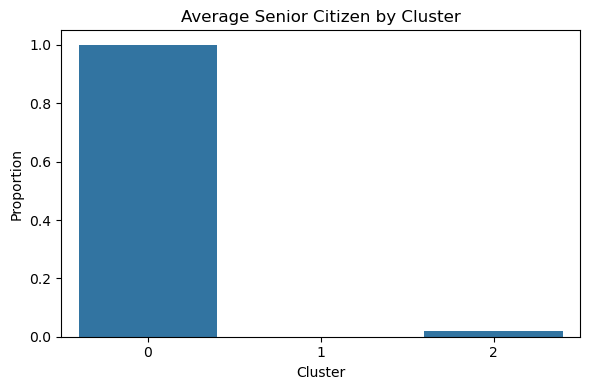

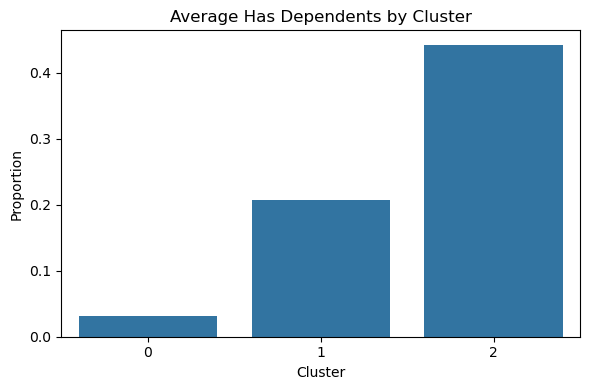

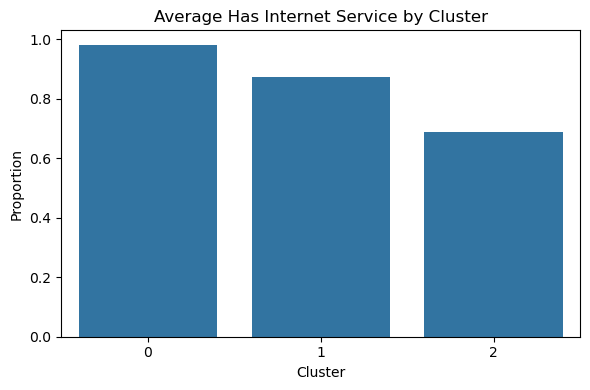

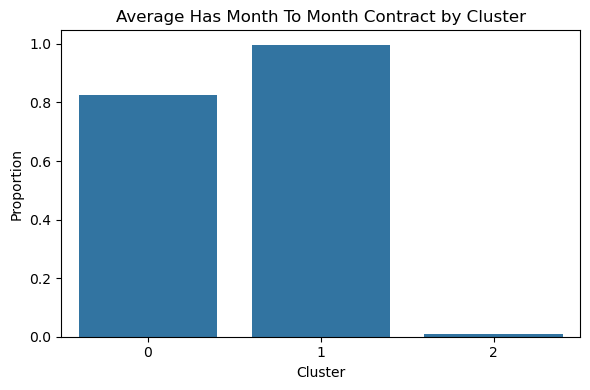

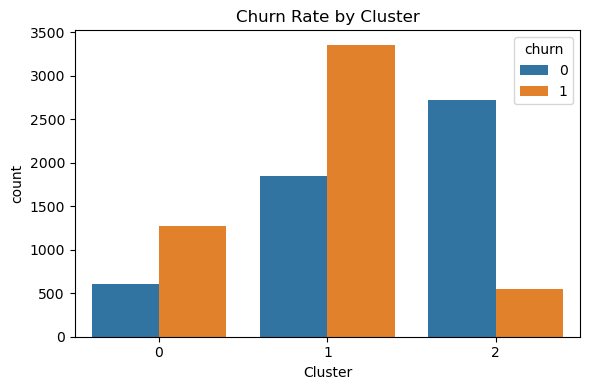

,churn,senior_citizen,has_dependents,months_as_cutomer,has_internet_service,has_month_to_month_contract
Cluster,,,,,,
0,0.676736,1.00000,0.030737,26.254902,0.981452,0.826709
1,0.645484,0.00000,0.207395,14.932987,0.874254,0.996534
2,0.166769,0.01836,0.442166,49.219094,0.687882,0.010404


In [20]:

# Create cluster-aware dataframe
df_clustered = pd.DataFrame(X_resampled, columns=X.columns)
df_clustered['churn'] = y_resampled
df_clustered['Cluster'] = clusters

# Profile each cluster by average values
profile = df_clustered.groupby('Cluster').agg({
    'senior_citizen': 'mean',
    'has_dependents': 'mean',
    'months_as_cutomer': 'mean',
    'has_internet_service': 'mean',
    'has_month_to_month_contract': 'mean',
    'churn': 'mean'  # average churn = % of churners
}).round(2)

print("📊 Cluster Profiles:")
display(profile)

# Visualize distributions
features_to_plot = ['senior_citizen', 'has_dependents', 'has_internet_service', 'has_month_to_month_contract']

for feature in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.barplot(data=df_clustered, x='Cluster', y=feature, ci=None)
    plt.title(f"Average {feature.replace('_', ' ').title()} by Cluster")
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()

# Plot churn rate by cluster again for reference
plt.figure(figsize=(6,4))
sns.countplot(x='Cluster', hue='churn', data=df_clustered)
plt.title("Churn Rate by Cluster")
plt.tight_layout()
plt.show()

df_clustered.groupby('Cluster').mean(numeric_only=True)[['churn', 'senior_citizen', 'has_dependents', 'months_as_cutomer', 'has_internet_service', 'has_month_to_month_contract']]


### 🔍 Interpretation by Cluster:
### Cluster 0
#### Moderate churn presence.

Churners ≈ Non-churners, but slightly more churners than retained customers.

Action: This group is relatively unstable — consider targeted retention efforts like discounts, better service, or loyalty programs.

### Cluster 1
#### Heavy churn segment!

Churners outnumber non-churners by a wide margin.

This cluster represents your most at-risk customers.

Action: High priority segment — analyze features (contract type, tenure, services) to understand why they churn.

### Cluster 2
#### Majority are non-churners.

Few customers churn.

This is your most loyal customer base.

Action: Understand what makes them stay (long tenure? bundled services?), and replicate that strategy for other clusters.

# Clustering Models : ii) Hierarchical Clustering

In [23]:
from scipy.cluster.hierarchy import linkage, fcluster

# Perform hierarchical clustering
linked = linkage(X_scaled, method='ward')

# Choose the number of clusters
hc_clusters = fcluster(linked, t=3, criterion='maxclust')  # you can change t=3 to however many clusters you want

📊 Hierarchical Cluster Profiles:


,senior_citizen,has_dependents,months_as_cutomer,has_internet_service,has_month_to_month_contract,churn
HC_Cluster,,,,,,
1,0.30,0.02,17.39,1.0,0.99,0.72
2,0.04,0.40,28.13,0.0,0.40,0.17
3,0.09,0.52,43.39,1.0,0.27,0.33


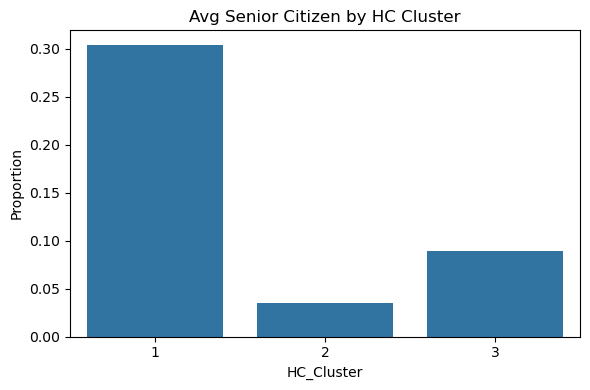

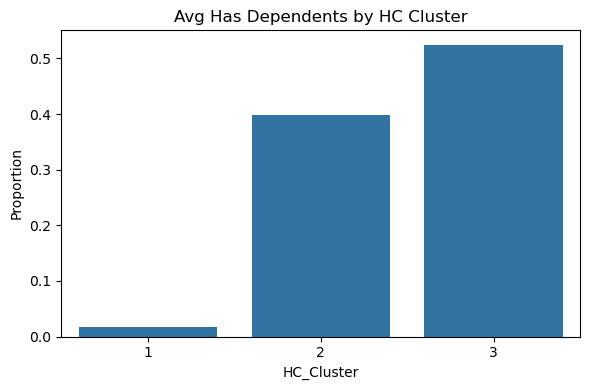

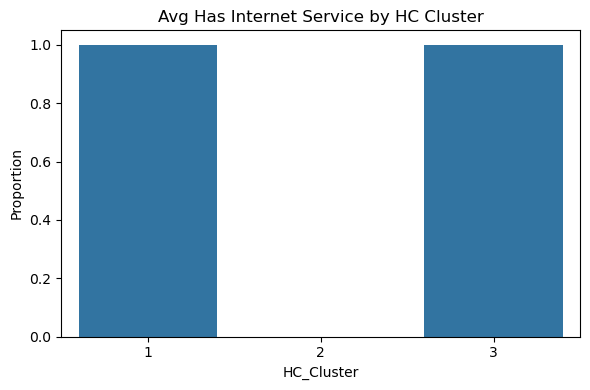

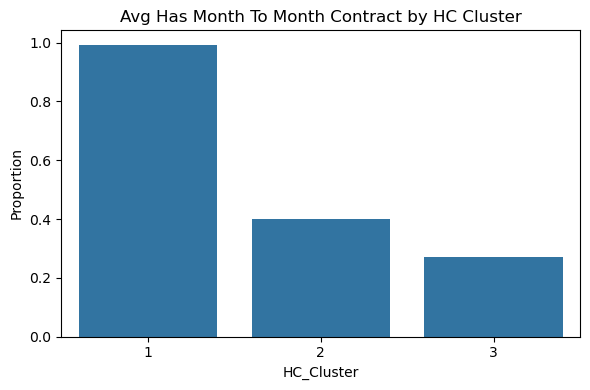

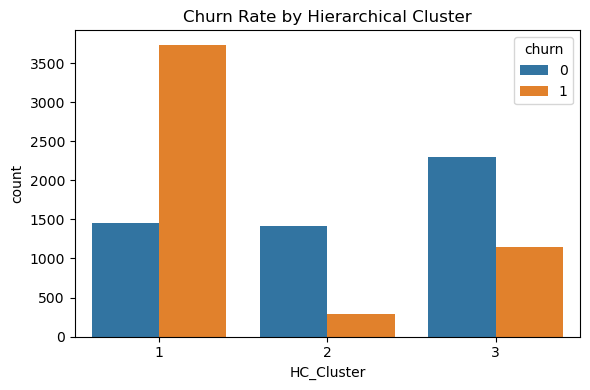

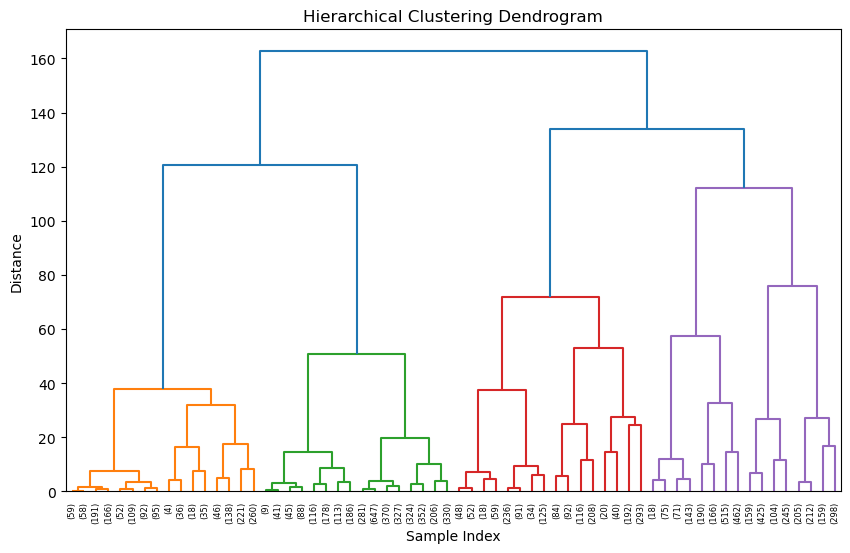

In [24]:
# Add HC cluster labels to the dataframe
df_clustered['HC_Cluster'] = hc_clusters

# Group by hierarchical cluster and analyze
hc_profile = df_clustered.groupby('HC_Cluster').agg({
    'senior_citizen': 'mean',
    'has_dependents': 'mean',
    'months_as_cutomer': 'mean',
    'has_internet_service': 'mean',
    'has_month_to_month_contract': 'mean',
    'churn': 'mean'
}).round(2)

print("📊 Hierarchical Cluster Profiles:")
display(hc_profile)

# Visualize churn rates and key feature distributions by HC cluster
features_to_plot = ['senior_citizen', 'has_dependents', 'has_internet_service', 'has_month_to_month_contract']

for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df_clustered, x='HC_Cluster', y=feature, ci=None)
    plt.title(f"Avg {feature.replace('_', ' ').title()} by HC Cluster")
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()

# Visualize churn distribution by HC cluster
plt.figure(figsize=(6, 4))
sns.countplot(x='HC_Cluster', hue='churn', data=df_clustered)
plt.title("Churn Rate by Hierarchical Cluster")
plt.tight_layout()
plt.show()

linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()



### Interpretation by Cluster:
### Cluster 1
#### 🔥 Highest churn (orange bars dominate).

This segment likely includes customers who are:

On month-to-month contracts

Possibly don’t have dependents

May have internet service with associated issues or costs

👉 High-risk group — prime candidates for churn mitigation efforts like retention campaigns or loyalty perks.

### Cluster 2
#### 💙 Low churn — this group is very stable.

Blue bars dominate, indicating they tend to stay.

This could include:

Senior citizens or those with longer tenure

Possibly more dependents or stable contracts

✅ Ideal customers — consider upselling or rewarding for loyalty.

### Cluster 3
#### ⚖️ Moderate churn — blue bars slightly outweigh orange.

This segment might be on the fence — not as loyal as Cluster 2, but not as risky as Cluster 1.

Could be influenced by:

Specific service issues

Billing or pricing sensitivity

🧪 Worth exploring feature distributions to nudge them toward retention.



### DBSCAN for reference

Cluster labels found: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


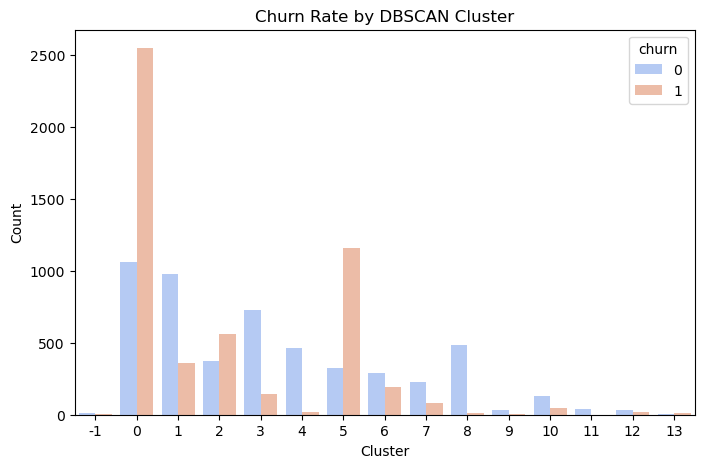

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Step 1: Scale the resampled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Step 2: DBSCAN clustering
db = DBSCAN(eps=0.5, min_samples=5)
db_clusters = db.fit_predict(X_scaled)

# Step 3: Prepare DataFrame
df_clustered = pd.DataFrame(X_resampled, columns=X.columns)
df_clustered['churn'] = y_resampled
df_clustered['Cluster'] = db_clusters

# Step 4: Show unique cluster labels (incl. noise -1)
print("Cluster labels found:", np.unique(db_clusters))

# Step 5: Visualize churn distribution per cluster
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', hue='churn', data=df_clustered, palette='coolwarm')
plt.title("Churn Rate by DBSCAN Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()
